#  Taxi order prediction

**The main objective of this project** is to predict the number of cab orders for the next hour in order to attract more drivers during peak periods. 

The customer has provided historical data on cab orders at airports. The number of orders is in the `num_orders` column.

**Plan of action:**
1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of size 10% of the original data.
4. Validate the data on the test sample and draw conclusions.

*Metric for model quality assessment: RMSE*

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor

In [2]:
data = pd.read_csv('/datasets/taxi.csv')
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Let's bring the `datetime` column to the expected data type and replace the existing index with it.

In [4]:
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
data.index.is_monotonic

True

The index is monotonically arranged, you can resample for each hour, calculating the total number of cab orders.

In [7]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Data analysis

Let's see what the data looks like on a graph:

In [8]:
# rolling mean
data['rolling_mean'] = data.rolling(3).mean()

In [9]:
def component_plot(component, title):
    if title == 'Тренд':
        data['rolling_mean'].plot(ax=plt.gca())
        
    component.plot(ax=plt.gca())
    plt.title(title)
    plt.show()

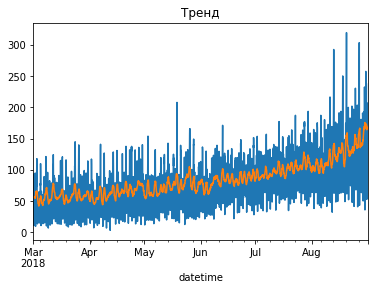

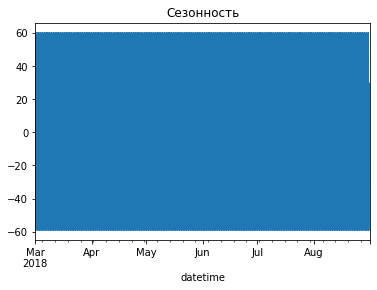

In [10]:
decomposed_data = seasonal_decompose(data[['num_orders']])

component_plot(decomposed_data.trend, 'Тренд')
component_plot(decomposed_data.seasonal, 'Сезонность')

The graph shows a smooth growth in the number of orders with each subsequent month.

It is difficult to distinguish seasonality over such a long period of time. However, it can probably be observed on a daily basis. Let's consider the "seasonality" of the number of orders for March 1 and 2, 2018:

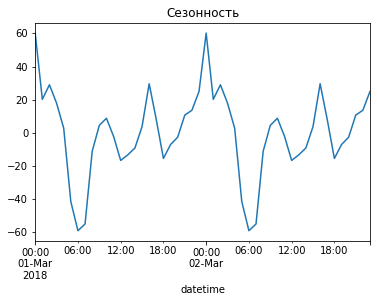

In [11]:
component_plot(decomposed_data.seasonal['2018-03-01': '2018-03-02'], 'Сезонность')

The peak of the total number of orders per hour is observed at midnight (we can assume that this is due to the end of public transportation), while the minimum is at 6 am.

## Model training

Before training the model, let's add new attributes to our dataset:
- calendar: month, day of the week, hour
- "lagged values": previous values of the time series
- moving average

In [12]:
def add_features(data, max_lag=3, rolling_n=2):
    new_data = data.copy(deep=True) 
    
    # calendar features
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    new_data['hour'] = new_data.index.hour
    
    # "lagged values"
    for lag in range(max_lag):
        new_data[f'lag_{lag+1}'] = new_data['num_orders'].shift(lag+1)
        
    # rolling mean
    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_n).mean()
    
    return new_data

In [13]:
data_with_features = add_features(data)
data_with_features.head()

,num_orders,rolling_mean,month,day,dayofweek,hour,lag_1,lag_2,lag_3
datetime,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,1,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,104.5,3,1,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,78.0,3,1,3,3,71.0,85.0,124.0
2018-03-01 04:00:00,43,68.5,3,1,3,4,66.0,71.0,85.0


Let's split the dataset into training and test sets:

In [14]:
train, test = train_test_split(data_with_features, shuffle=False, test_size=0.1)
train = train.dropna()

# train
features_train = train.drop(columns=['num_orders'])
target_train = train['num_orders']

# test
features_test = test.drop(columns=['num_orders'])
target_test = test['num_orders']

features_train.shape, features_test.shape

((3971, 8), (442, 8))

In [15]:
# scaling
scaler = StandardScaler()
scaler.fit(features_train)
cols = features_train.columns

features_train = pd.DataFrame(scaler.transform(features_train), columns=cols)
features_test = pd.DataFrame(scaler.transform(features_test), columns=cols)

In [16]:
features_train.head()

,rolling_mean,month,day,dayofweek,hour,lag_1,lag_2,lag_3
0,-0.007790,-1.412939,-1.592432,-0.01283,-1.227447,-0.187932,0.174161,1.183080
1,-0.285686,-1.412939,-1.592432,-0.01283,-1.082877,-0.317234,-0.187889,0.174324
2,-0.695217,-1.412939,-1.592432,-0.01283,-0.938306,-0.912023,-0.317192,-0.187794
3,-1.572782,-1.412939,-1.592432,-0.01283,-0.793736,-1.868857,-0.911988,-0.317122
4,-2.026192,-1.412939,-1.592432,-0.01283,-0.649165,-1.713694,-1.868834,-0.912029


Let's compare 2 different algorithms, *Random Forest* and *Gradient boosting*.

In [17]:
%%time

# Random forest
params = {
    'n_estimators': range(50, 200, 50),
    'max_depth': range(3, 8)
}

model = RandomForestRegressor()

cv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(estimator=model, cv=cv, param_grid=params, scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)

# the best model
forest_model = grid.best_estimator_

print('RMSE на обучающей выборке:', -grid.best_score_)
print('Гиперпараметры:', grid.best_params_)

RMSE на обучающей выборке: 26.793346176893373
Гиперпараметры: {'max_depth': 7, 'n_estimators': 50}
CPU times: user 22.8 s, sys: 87.3 ms, total: 22.8 s
Wall time: 22.9 s


In [18]:
%%time

# Gradient boosting
params = {
    'learning_rate': [0.5, 1],
    'n_estimators': range(50, 200, 50),
    'max_depth': range(3, 8)
}

model = LGBMRegressor()

cv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(estimator=model, cv=cv, param_grid=params, scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)

# the best model
lgbm_model = grid.best_estimator_

print('RMSE на обучающей выборке:', -grid.best_score_)
print('Гиперпараметры:', grid.best_params_)

RMSE на обучающей выборке: 25.82375298383868
Гиперпараметры: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 50}
CPU times: user 9min 22s, sys: 4.63 s, total: 9min 27s
Wall time: 9min 35s


The model trained by the gradient boosting algorithm showed the best results on the training set. Let's test it on the test set.

## Final testing

In [19]:
preds = lgbm_model.predict(features_test)
print('RMSE на тестовой выборке:', mean_squared_error(target_test, preds, squared=False))

RMSE на тестовой выборке: 44.74145889798763


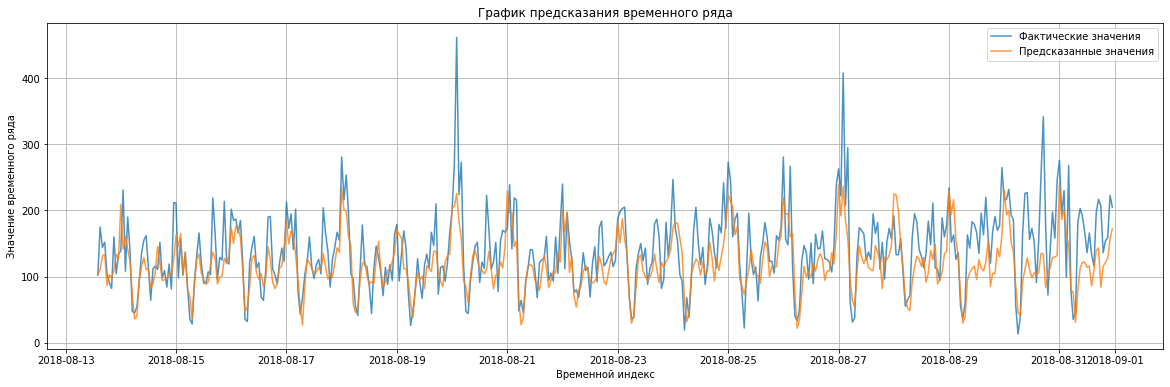

In [20]:
plt.figure(figsize=(20, 6))
plt.plot(target_test.index, target_test, label='Фактические значения', alpha=0.8)
plt.plot(target_test.index, preds, label='Предсказанные значения', alpha=0.8)
plt.xlabel('Временной индекс')
plt.ylabel('Значение временного ряда')
plt.title('График предсказания временного ряда')
plt.legend()
plt.grid(True)
plt.show()

**Conclusion:**

This project required building a model to predict the number of cab orders for the next hour. The provided data was processed and analyzed, also resampling by hour and adding several new features including time variables (month, day of the week, day, hour) and "lagged values". 

At the end of testing, the model trained with the *gradient boosting* algorithm performed the best compared to the *random forest* (although the difference in error was small). The lowest error value obtained was **RMSE=8.8** (*learning_rate=0.5, n_estimators=50, max_depth=3*)